In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
! pip install monai
import monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 20.4 MB/s eta 0:00:00


In [ ]:
from typing import List, Tuple, Union
import numpy as np
import torch
from monai.data import DataLoader, Dataset, CacheDataset, decollate_batch
from monai.transforms import (
    Compose,
    EnsureChannelFirstd,
    Orientationd,
    AsDiscrete,
    RandFlipd,
    RandRotate90d,
    NormalizeIntensityd,
    RandCropByLabelClassesd,
)

## Define some helper functions


### Patching helper functions

These are mostly used to split large volumes into smaller ones and stitch them back together.

In [ ]:
def calculate_patch_starts(dimension_size: int, patch_size: int) -> List[int]:
    """
    Calculate the starting positions of patches along a single dimension
    with minimal overlap to cover the entire dimension.

    Parameters:
    -----------
    dimension_size : int
        Size of the dimension
    patch_size : int
        Size of the patch in this dimension

    Returns:
    --------
    List[int]
        List of starting positions for patches
    """
    if dimension_size <= patch_size:
        return [0]

    # Calculate number of patches needed
    n_patches = np.ceil(dimension_size / patch_size)

    if n_patches == 1:
        return [0]

    # Calculate overlap
    total_overlap = (n_patches * patch_size - dimension_size) / (n_patches - 1)

    # Generate starting positions
    positions = []
    for i in range(int(n_patches)):
        pos = int(i * (patch_size - total_overlap))
        if pos + patch_size > dimension_size:
            pos = dimension_size - patch_size
        if pos not in positions:  # Avoid duplicates
            positions.append(pos)

    return positions

def extract_3d_patches_minimal_overlap(arrays: List[np.ndarray], patch_size: int) -> Tuple[List[np.ndarray], List[Tuple[int, int, int]]]:
    """
    Extract 3D patches from multiple arrays with minimal overlap to cover the entire array.

    Parameters:
    -----------
    arrays : List[np.ndarray]
        List of input arrays, each with shape (m, n, l)
    patch_size : int
        Size of cubic patches (a x a x a)

    Returns:
    --------
    patches : List[np.ndarray]
        List of all patches from all input arrays
    coordinates : List[Tuple[int, int, int]]
        List of starting coordinates (x, y, z) for each patch
    """
    if not arrays or not isinstance(arrays, list):
        raise ValueError("Input must be a non-empty list of arrays")

    # Verify all arrays have the same shape
    shape = arrays[0].shape
    if not all(arr.shape == shape for arr in arrays):
        raise ValueError("All input arrays must have the same shape")

    if patch_size > min(shape):
        raise ValueError(f"patch_size ({patch_size}) must be smaller than smallest dimension {min(shape)}")

    m, n, l = shape
    patches = []
    coordinates = []

    # Calculate starting positions for each dimension
    x_starts = calculate_patch_starts(m, patch_size)
    y_starts = calculate_patch_starts(n, patch_size)
    z_starts = calculate_patch_starts(l, patch_size)

    # Extract patches from each array
    for arr in arrays:
        for x in x_starts:
            for y in y_starts:
                for z in z_starts:
                    patch = arr[
                        x:x + patch_size,
                        y:y + patch_size,
                        z:z + patch_size
                    ]
                    patches.append(patch)
                    coordinates.append((x, y, z))

    return patches, coordinates

# Note: I should probably averge the overlapping areas,
# but here they are just overwritten by the most recent one.

def reconstruct_array(patches: List[np.ndarray],
                     coordinates: List[Tuple[int, int, int]],
                     original_shape: Tuple[int, int, int]) -> np.ndarray:
    """
    Reconstruct array from patches.

    Parameters:
    -----------
    patches : List[np.ndarray]
        List of patches to reconstruct from
    coordinates : List[Tuple[int, int, int]]
        Starting coordinates for each patch
    original_shape : Tuple[int, int, int]
        Shape of the original array

    Returns:
    --------
    np.ndarray
        Reconstructed array
    """
    reconstructed = np.zeros(original_shape, dtype=np.int64)  # To track overlapping regions

    patch_size = patches[0].shape[0]

    for patch, (x, y, z) in zip(patches, coordinates):
        reconstructed[
            x:x + patch_size,
            y:y + patch_size,
            z:z + patch_size
        ] = patch


    return reconstructed

## Submission helper functions

These help with getting the submission in the correct format

In [ ]:
import pandas as pd

def dict_to_df(coord_dict, experiment_name):
    """
    Convert dictionary of coordinates to pandas DataFrame.

    Parameters:
    -----------
    coord_dict : dict
        Dictionary where keys are labels and values are Nx3 coordinate arrays

    Returns:
    --------
    pd.DataFrame
        DataFrame with columns ['x', 'y', 'z', 'label']
    """
    # Create lists to store data
    all_coords = []
    all_labels = []

    # Process each label and its coordinates
    for label, coords in coord_dict.items():
        all_coords.append(coords)
        all_labels.extend([label] * len(coords))

    # Concatenate all coordinates
    all_coords = np.vstack(all_coords)

    df = pd.DataFrame({
        'experiment': experiment_name,
        'particle_type': all_labels,
        'x': all_coords[:, 0],
        'y': all_coords[:, 1],
        'z': all_coords[:, 2]
    })


    return df

## Reading in the data

In [ ]:
TRAIN_DATA_DIR = "/content/drive/MyDrive/kaggle/input/create-numpy-dataset-exp-name"
# TEST_DATA_DIR = "/content/drive/MyDrive/kaggle/input/czii-cryo-et-object-identification"

In [ ]:
train_names = ['TS_5_4', 'TS_69_2', 'TS_6_6', 'TS_73_6', 'TS_86_3', 'TS_99_9']
valid_names = ['TS_6_4']

train_files = []
valid_files = []

for name in train_names:
    image = np.load(f"{TRAIN_DATA_DIR}/train_image_{name}.npy")
    label = np.load(f"{TRAIN_DATA_DIR}/train_label_{name}.npy")

    train_files.append({"image": image, "label": label})
    # # print(f"image:{image}, label:{label}")
    # print(len(image))
    # print(len(label))


for name in valid_names:
    image = np.load(f"{TRAIN_DATA_DIR}/train_image_{name}.npy")
    label = np.load(f"{TRAIN_DATA_DIR}/train_label_{name}.npy")

    valid_files.append({"image": image, "label": label})



### Create the training dataloader

I should probably find a way to create a dataloader that takes more batches.

In [ ]:
# Non-random transforms to be cached
non_random_transforms = Compose([
    EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),
    NormalizeIntensityd(keys="image"),
    Orientationd(keys=["image", "label"], axcodes="RAS")
])

raw_train_ds = CacheDataset(data=train_files, transform=non_random_transforms, cache_rate=1.0)


my_num_samples = 16
train_batch_size = 1

# Random transforms to be applied during training
random_transforms = Compose([
    RandCropByLabelClassesd(
        keys=["image", "label"],
        label_key="label",
        spatial_size=[16, 16, 16],
        num_classes=7,
        num_samples=my_num_samples
    ),
    RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=[0, 2]),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
])

train_ds = Dataset(data=raw_train_ds, transform=random_transforms)


# DataLoader remains the same
train_loader = DataLoader(
    train_ds,
    batch_size=train_batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=torch.cuda.is_available()
)

Loading dataset: 100%|██████████| 6/6 [00:01<00:00,  5.70it/s]


### Create the validation dataloader

Here I deviate a little from the source notebooks.

In the source, the validation dataloader also used the random transformations. This is bad practice and will result in noisy validation.

Here I split the validation dataset in (slightly) overlapping blocks of `(96, 96 , 96)` so that we can have a consistent validation set that uses all the validation data.


In [ ]:
val_images,val_labels = [dcts['image'] for dcts in valid_files],[dcts['label'] for dcts in valid_files]

val_image_patches, _ = extract_3d_patches_minimal_overlap(val_images, 96)
val_label_patches, _ = extract_3d_patches_minimal_overlap(val_labels, 96)

val_patched_data = [{"image": img, "label": lbl} for img, lbl in zip(val_image_patches, val_label_patches)]


valid_ds = CacheDataset(data=val_patched_data, transform=non_random_transforms, cache_rate=1.0)


valid_batch_size = 16
# DataLoader remains the same
valid_loader = DataLoader(
    valid_ds,
    batch_size=valid_batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=torch.cuda.is_available()
)

Loading dataset: 100%|██████████| 98/98 [00:00<00:00, 161.53it/s]


## Initialize the model

This model is pretty much directly copied from [3D U-Net PyTorch Lightning distributed training](https://www.kaggle.com/code/zhuowenzhao11/3d-u-net-pytorch-lightning-distributed-training)

In [ ]:
!pip install lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 9.5 MB/s eta 0:00:00


In [ ]:
import lightning.pytorch as pl

from monai.networks.nets import UNet
from monai.networks.nets import EfficientNet
from monai.networks.nets import AttentionUnet
from monai.losses import TverskyLoss
from monai.metrics import DiceMetric

class Model_ATT(pl.LightningModule):
    def __init__(
        self,
        spatial_dims: int = 3,
        in_channels: int = 1,
        out_channels: int = 7,
        channels: Union[Tuple[int, ...], List[int]] = (48, 64, 80, 80),
        strides: Union[Tuple[int, ...], List[int]] = (2, 2, 1),
        num_res_units: int = 1,
        lr: float=1e-3):

        super().__init__()
        self.save_hyperparameters()
        self.model = AttentionUnet(
            spatial_dims=self.hparams.spatial_dims,
            in_channels=self.hparams.in_channels,
            out_channels=self.hparams.out_channels,
            channels=self.hparams.channels,
            strides=self.hparams.strides,
            # num_res_units=self.hparams.num_res_units,
        )
        self.loss_fn = TverskyLoss(include_background=True, to_onehot_y=True, softmax=True)  # softmax=True for multiclass
        self.metric_fn = DiceMetric(include_background=False, reduction="mean", ignore_empty=True)

        self.train_loss = 0
        self.val_metric = 0
        self.num_train_batch = 0
        self.num_val_batch = 0

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch['image'], batch['label']
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.train_loss += loss
        self.num_train_batch += 1
        torch.cuda.empty_cache()
        return loss

    def on_train_epoch_end(self):
        loss_per_epoch = self.train_loss/self.num_train_batch
        #print(f"Epoch {self.current_epoch} - Average Train Loss: {loss_per_epoch:.4f}")
        self.log('train_loss', loss_per_epoch, prog_bar=True)
        self.train_loss = 0
        self.num_train_batch = 0

    def validation_step(self, batch, batch_idx):
        with torch.no_grad(): # This ensures that gradients are not stored in memory
            x, y = batch['image'], batch['label']
            y_hat = self(x)
            metric_val_outputs = [AsDiscrete(argmax=True, to_onehot=self.hparams.out_channels)(i) for i in decollate_batch(y_hat)]
            metric_val_labels = [AsDiscrete(to_onehot=self.hparams.out_channels)(i) for i in decollate_batch(y)]

            # compute metric for current iteration
            self.metric_fn(y_pred=metric_val_outputs, y=metric_val_labels)
            metrics = self.metric_fn.aggregate(reduction="mean_batch")
            val_metric = torch.mean(metrics) # I used mean over all particle species as the metric. This can be explored.
            self.val_metric += val_metric
            self.num_val_batch += 1
        torch.cuda.empty_cache()
        return {'val_metric': val_metric}

    def on_validation_epoch_end(self):
        metric_per_epoch = self.val_metric/self.num_val_batch
        #print(f"Epoch {self.current_epoch} - Average Val Metric: {metric_per_epoch:.4f}")
        self.log('val_metric', metric_per_epoch, prog_bar=True, sync_dist=False) # sync_dist=True for distributed training
        self.val_metric = 0
        self.num_val_batch = 0

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)

In [ ]:
channels = (48, 64, 80, 80)
strides_pattern = (2, 2, 1)
num_res_units = 1
learning_rate = 1e-3
num_epochs = 100

model_1 = Model_ATT(channels=channels, strides=strides_pattern, num_res_units=num_res_units, lr=learning_rate)

## Train the model



In [ ]:

torch.set_float32_matmul_precision('medium')

# Check if CUDA is available and then count the GPUs
if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs available: {num_gpus}")
else:
    print("No GPU available. Running on CPU.")
devices = list(range(num_gpus))
print(devices)


trainer = pl.Trainer(
    max_epochs=num_epochs,
    #strategy="ddp_notebook",
    accelerator="gpu",
    devices=[0],# devices
    num_nodes=1,
    log_every_n_steps=10,
    enable_progress_bar=True,
)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Number of GPUs available: 1
[0]


Let there be gradients!

Locally this config seems to train for about 1000 steps before the model starts overfitting.

In [ ]:
trainer.fit(model_1, train_loader, valid_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name    | Type          | Params | Mode 
--------------------------------------------------
0 | model   | AttentionUnet | 2.0 M  | train
1 | loss_fn | TverskyLoss   | 0      | train
--------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.060     Total estimated model params size (MB)
150       Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name    | Type          | Params | Mode 
--------------------------------------------------
0 | model   | AttentionUnet | 2.0 M  | train
1 | loss_fn | TverskyLoss   | 0      | train
--------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.060     Total estimated model params size (MB)
150       Modules

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


## Predict on the test set



In [ ]:
model_1.eval();
model_1.to("cuda");

In [ ]:
import json
# copick_config_path = TRAIN_DATA_DIR + "/copick.config"
copick_config_path ="/content/copick.config"

with open(copick_config_path) as f:
    copick_config = json.load(f)

copick_config['static_root'] = '/content/drive/MyDrive/kaggle/input/czii-cryo-et-object-identification/test/static'

copick_test_config_path = 'copick_test.config'

with open(copick_test_config_path, 'w') as outfile:
    json.dump(copick_config, outfile)

In [ ]:
!pip install copick

In [ ]:
import copick

root = copick.from_file(copick_test_config_path)

copick_user_name = "copickUtils"
copick_segmentation_name = "paintedPicks"
voxel_size = 10
tomo_type = "denoised"

In [ ]:
# Non-random transforms to be cached
inference_transforms = Compose([
    EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
    NormalizeIntensityd(keys="image"),
    Orientationd(keys=["image"], axcodes="RAS")
])

In [ ]:
!pip install connected-components-3d
import cc3d

id_to_name = {1: "apo-ferritin",
              2: "beta-amylase",
              3: "beta-galactosidase",
              4: "ribosome",
              5: "thyroglobulin",
              6: "virus-like-particle"}

### Iterate over test set


Below we will:
1. Read in a run
2. Split it into patches of size (96, 96, 96)
3. Create a dataset from the patches
4. Predict the segmentation mask
5. Glue the mask back together
6. Find the connected components for each class
7. Find the centroids of the connected components
8. Add to the dataframe

Then do this for all runs.

This can probably be optimized quite a bit.

In [ ]:
BLOB_THRESHOLD = 500
CERTAINTY_THRESHOLD = 0.5

classes = [1, 2, 3, 4, 5, 6]
with torch.no_grad():
    location_df_1 = []
    for run in root.runs:
        print(run)

        tomo = run.get_voxel_spacing(10)
        tomo = tomo.get_tomogram(tomo_type).numpy()

        tomo_patches, coordinates  = extract_3d_patches_minimal_overlap([tomo], 96)

        tomo_patched_data = [{"image": img} for img in tomo_patches]

        tomo_ds = CacheDataset(data=tomo_patched_data, transform=inference_transforms, cache_rate=1.0)

        pred_masks = []

        for i in range(len(tomo_ds)):
            input_tensor = tomo_ds[i]['image'].unsqueeze(0).to("cuda")
            # 在使用模型之前，将模型移到 GPU
            model_1 = model_1.to("cuda")
            model_output = model_1(input_tensor)

            probs = torch.softmax(model_output[0], dim=0)
            thresh_probs = probs > CERTAINTY_THRESHOLD
            _, max_classes = thresh_probs.max(dim=0)

            pred_masks.append(max_classes.cpu().numpy())


        reconstructed_mask = reconstruct_array(pred_masks, coordinates, tomo.shape)

        location = {}

        for c in classes:
            cc = cc3d.connected_components(reconstructed_mask == c)
            stats = cc3d.statistics(cc)
            zyx=stats['centroids'][1:]*10.012444 #https://www.kaggle.com/competitions/czii-cryo-et-object-identification/discussion/544895#3040071
            zyx_large = zyx[stats['voxel_counts'][1:] > BLOB_THRESHOLD]
            xyz =np.ascontiguousarray(zyx_large[:,::-1])

            location[id_to_name[c]] = xyz


        df = dict_to_df(location, run.name)
        location_df_1.append(df)

    location_df_1 = pd.concat(location_df_1)

CopickRun(name=TS_5_4, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x7e0eba7179a0


<ipython-input-52-2b62e64763ca>:11: DeprecationWarning: get_tomogram is deprecated, use get_tomograms instead. Results may be incomplete
  tomo = tomo.get_tomogram(tomo_type).numpy()
Loading dataset: 100%|██████████| 98/98 [00:00<00:00, 105.87it/s]


CopickRun(name=TS_69_2, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x7e0eba716a10


Loading dataset: 100%|██████████| 98/98 [00:00<00:00, 108.27it/s]


CopickRun(name=TS_6_4, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x7e0eba717b20


Loading dataset: 100%|██████████| 98/98 [00:00<00:00, 146.49it/s]


In [ ]:
location_df_1.insert(loc=0, column='id', value=np.arange(len(location_df_1)))
location_df_1.to_csv("submission.csv", index=False)

In [ ]:
!ls

copick.config	    drive	    sample_data		    train_image_TS_6_6.npy
copick_test.config  lightning_logs  sample_submission.csv   train_image_TS_69_2.npy
czii_helper.py	    model2.py	    submission.csv	    train_image_TS_73_6.npy
dataset.py	    model.py	    train_image_TS_5_4.npy  train_image_TS_86_3.npy
decoder.py	    __pycache__     train_image_TS_6_4.npy


In [ ]:
from czii_helper import *
from dataset import *
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt

['TS_5_4', 'TS_69_2', 'TS_6_4']
 TS_6_4 virus-like-particle
         particle_type    P    T  hit  miss   fp  precision  recall  f-beta4  \
0         apo-ferritin   21  139    0   139   21        0.0     0.0      0.0   
1         beta-amylase   78   31    0    31   78        0.0     0.0      0.0   
2   beta-galactosidase  378   40    0    40  378        0.0     0.0      0.0   
3             ribosome    0  142    0   142    0        0.0     0.0      0.0   
4        thyroglobulin  426   94    0    94  426        0.0     0.0      0.0   
5  virus-like-particle    0   30    0    30    0        0.0     0.0      0.0   

   weight  
0       1  
1       0  
2       2  
3       1  
4       2  
5       1  
lb_score: 0.0

TS_6_4 apo-ferritin
	 num truth   : 58
	 num predict : 7
	 num hit  : 0
	 num fp   : 7
	 num miss : 58
TS_6_4 beta-amylase
	 num truth   : 9
	 num predict : 26
	 num hit  : 0
	 num fp   : 26
	 num miss : 9
TS_6_4 beta-galactosidase
	 num truth   : 12
	 num predict : 126
	 num hit

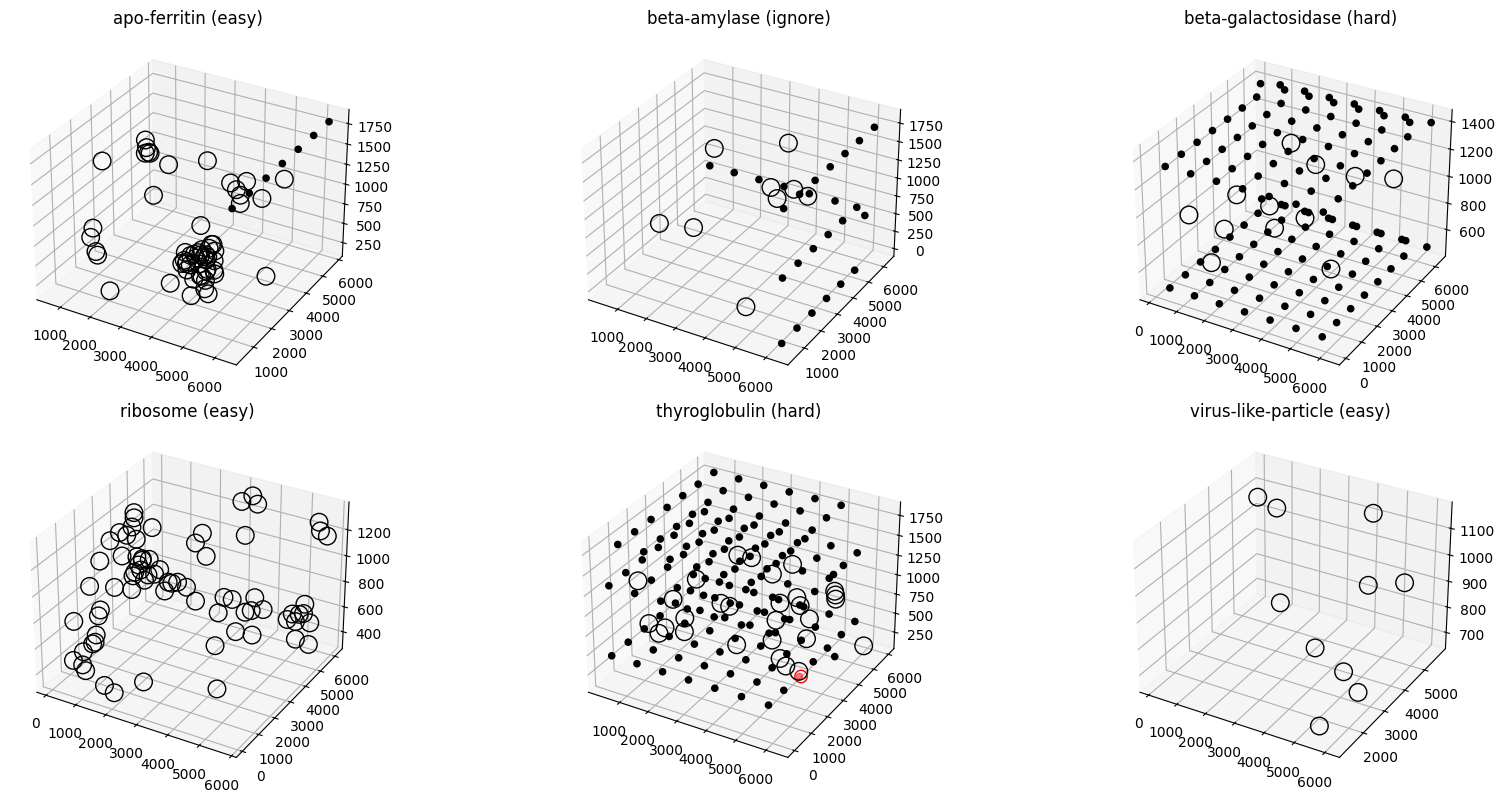

In [ ]:
import os
if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    MODE = 'submit'
else:
    MODE = 'local'







valid_dir ='/content/drive/MyDrive/kaggle/input/czii-cryo-et-object-identification/train'
valid_id = ['TS_6_4', ]

def do_one_eval(truth, predict, threshold):
    P=len(predict)
    T=len(truth)

    if P==0:
        hit=[[],[]]
        miss=np.arange(T).tolist()
        fp=[]
        metric = [P,T,len(hit[0]),len(miss),len(fp)]
        return hit, fp, miss, metric

    if T==0:
        hit=[[],[]]
        fp=np.arange(P).tolist()
        miss=[]
        metric = [P,T,len(hit[0]),len(miss),len(fp)]
        return hit, fp, miss, metric

    #---
    distance = predict.reshape(P,1,3)-truth.reshape(1,T,3)
    distance = distance**2
    distance = distance.sum(axis=2)
    distance = np.sqrt(distance)
    p_index, t_index = linear_sum_assignment(distance)

    valid = distance[p_index, t_index] <= threshold
    p_index = p_index[valid]
    t_index = t_index[valid]
    hit = [p_index.tolist(), t_index.tolist()]
    miss = np.arange(T)
    miss = miss[~np.isin(miss,t_index)].tolist()
    fp = np.arange(P)
    fp = fp[~np.isin(fp,p_index)].tolist()

    metric = [P,T,len(hit[0]),len(miss),len(fp)] #for lb metric F-beta copmutation
    return hit, fp, miss, metric


def compute_lb(submit_df, overlay_dir):
    valid_id = list(submit_df['experiment'].unique())
    print(valid_id)

    eval_df = []
    for id in valid_id:
        truth = read_one_truth(id, overlay_dir) #=f'{valid_dir}/overlay/ExperimentRuns')
        id_df = submit_df[submit_df['experiment'] == id]
        for p in PARTICLE:
            p = dotdict(p)
            print('\r', id, p.name, end='', flush=True)
            xyz_truth = truth[p.name]
            xyz_predict = id_df[id_df['particle_type'] == p.name][['x', 'y', 'z']].values
            hit, fp, miss, metric = do_one_eval(xyz_truth, xyz_predict, p.radius* 0.5)
            eval_df.append(dotdict(
                id=id, particle_type=p.name,
                P=metric[0], T=metric[1], hit=metric[2], miss=metric[3], fp=metric[4],
            ))
    print('')
    eval_df = pd.DataFrame(eval_df)
    gb = eval_df.groupby('particle_type').agg('sum').drop(columns=['id'])
    gb.loc[:, 'precision'] = gb['hit'] / gb['P']
    gb.loc[:, 'precision'] = gb['precision'].fillna(0)
    gb.loc[:, 'recall'] = gb['hit'] / gb['T']
    gb.loc[:, 'recall'] = gb['recall'].fillna(0)
    gb.loc[:, 'f-beta4'] = 17 * gb['precision'] * gb['recall'] / (16 * gb['precision'] + gb['recall'])
    gb.loc[:, 'f-beta4'] = gb['f-beta4'].fillna(0)

    gb = gb.sort_values('particle_type').reset_index(drop=False)
    # https://www.kaggle.com/competitions/czii-cryo-et-object-identification/discussion/544895
    gb.loc[:, 'weight'] = [1, 0, 2, 1, 2, 1]
    lb_score = (gb['f-beta4'] * gb['weight']).sum() / gb['weight'].sum()
    return gb, lb_score


#debug
if 1:
    if MODE=='local':
    #if 1:
        submit_df=pd.read_csv(
           'submission.csv'
            # '/kaggle/input/hengck-czii-cryo-et-weights-01/submission.csv'
        )
        gb, lb_score = compute_lb(submit_df, f'{valid_dir}/overlay/ExperimentRuns')
        print(gb)
        print('lb_score:',lb_score)
        print('')


        #show one ----------------------------------
        fig = plt.figure(figsize=(18, 8))

        id = valid_id[0]
        truth = read_one_truth(id,overlay_dir=f'{valid_dir}/overlay/ExperimentRuns')

        submit_df = submit_df[submit_df['experiment']==id]
        for p in PARTICLE:
            p = dotdict(p)
            xyz_truth = truth[p.name]
            xyz_predict = submit_df[submit_df['particle_type']==p.name][['x','y','z']].values
            hit, fp, miss, _ = do_one_eval(xyz_truth, xyz_predict, p.radius)
            print(id, p.name)
            print('\t num truth   :',len(xyz_truth) )
            print('\t num predict :',len(xyz_predict) )
            print('\t num hit  :',len(hit[0]) )
            print('\t num fp   :',len(fp) )
            print('\t num miss :',len(miss) )

            ax = fig.add_subplot(2, 3, p.label, projection='3d')
            if hit[0]:
                pt = xyz_predict[hit[0]]
                ax.scatter(pt[:, 0], pt[:, 1], pt[:, 2], alpha=0.5, color='r')
                pt = xyz_truth[hit[1]]
                ax.scatter(pt[:,0], pt[:,1], pt[:,2], s=80, facecolors='none', edgecolors='r')
            if fp:
                pt = xyz_predict[fp]
                ax.scatter(pt[:, 0], pt[:, 1], pt[:, 2], alpha=1, color='k')
            if miss:
                pt = xyz_truth[miss]
                ax.scatter(pt[:, 0], pt[:, 1], pt[:, 2], s=160, alpha=1, facecolors='none', edgecolors='k')

            ax.set_title(f'{p.name} ({p.difficulty})')

        plt.tight_layout()
        plt.show()

        #---
        zz=0